In [1]:
import random
import torch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import inspect
import time
import pandas as pd
import json
import random
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
import torch.optim as optim
import torch.nn

In [2]:
with open("NO_PUNCT/DESCRIPTION.json","r") as f:
    preproc_descr = json.load(f)
with open("SHARED/PROJECT_A.json","r") as t:
    tickets = json.load(t)
with open("NO_PUNCT/SUMMARIES.json","r") as s:
    summaries = json.load(s)
assert len(preproc_descr) == len(tickets) == len(summaries), "Wrong dimensions"

# joining summary and description into a single list
for i in range(len(summaries)):
    summaries[i].extend(preproc_descr[i])
    
df = pd.DataFrame(tickets, columns=["ID","bug_cat","labels","components","priority","summary","description"])
descr_ = pd.Series(summaries)
df["preproc_descr"] = descr_
df.drop(["description","summary","labels","components","priority"],axis=1,inplace=True)

#### 1) data augmentation 2)padding/clipping 4)pre-modeling 5)modeling

##### Why not oversampling? -->EASY DATA AUGMENTATION is not that easy: I noticed that replacing  random words with their synonims using wordnet.sysnet generated meaningless sentences and nlpaug tokenizer does not work correctly since neither stopwords nor stopwords_regex as today (02/2022). Back Translation would cost me 200 € ......hence undersampling :-P

In [3]:
idx_mainclass = []
idx_dropclass = []
for i in range(len(df)):
    if df.loc[i,"bug_cat"] == "YOUR_FIRST_CATEGORY":
        idx_mainclass.append(i)
    elif df.loc[i,"bug_cat"] == "YOUR_SECOND_CATEGORY":
        idx_dropclass.append(i)
idx_drop = list(np.random.choice(idx_mainclass, int(len(idx_mainclass)*0.4), replace=False))
idx_drop.extend(idx_dropclass)
df = df.drop(labels=idx_drop, axis=0).reset_index().drop("index",axis=1)
lengths = []
for i in df["preproc_descr"]:
    lengths.append(len(i))
df["length"] = lengths
labels = df["bug_cat"].tolist()
tickets = df["preproc_descr"].tolist()
lengths = df["length"].tolist()
assert len(labels) == len(tickets) == len(lengths), "Dimensions are wrong"

#### clipping the lenght of tickets after the 99 percentile to remove outliers

In [4]:
int(np.percentile(lengths,99))

240

In [5]:
threshold = int(np.percentile(lengths,99))
#threshold = 200
for i in range(len(tickets)):
    if lengths[i] > threshold:       
        text = tickets[i]
        tickets[i] = text[:threshold]

In [6]:
from collections import Counter
# mindblowing but sexy
concat_list = [j for i in tickets for j in i]

In [7]:
def vocab_to_int(text,threshold):
    counts = dict(Counter(text))
    counts = dict(sorted(counts.items(), key=lambda x: x[1],reverse=True))
    filtered = [word for word in counts.keys() if counts[word]>=threshold]
    new_list = {word:ii for ii, word in enumerate(filtered,1)}
    return new_list
vocab_2_int =vocab_to_int(concat_list,5)
print(len(Counter(concat_list)),"--",len(vocab_2_int))

20502 -- 4990


In [11]:
num_tickets = []
for ticket in tickets:
    new_ticket = [vocab_2_int[word] for word in ticket if word in vocab_2_int.keys()]
    num_tickets.append(new_ticket)

In [12]:
lenght_clipped = []
for i in num_tickets:
    lenght_clipped.append(len(i))
assert max(lenght_clipped) == threshold, "Clipping did not work"

### PADDING --> all lists will have length == threshold

In [14]:
# APPLYING PRE-PADDING THAT WORKS BETTER THAN POST-PADDING
def pad_sequence(text,threshold):
    if len(text) < threshold:
        text = list(np.zeros(threshold-len(text))) + text
    return text
    
num_tickets = [pad_sequence(num_tickets[i],threshold) for i in range(len(num_tickets))]

lengths = [len(i) for i in num_tickets]
assert sum(lengths)/len(lengths) == max(lengths), "PADDING DID NOT WORK CORRECTLY"

In [15]:
modeling = [[num_tickets[i],labels[i]] for i in range(len(num_tickets))]
for i in modeling:
    if i[1] == "YOUR_FIRST_CATEGORY":
        i[1] = 1
    else:
        i[1] = 0

In [16]:
#with open("NO_PUNCT/modeling.json","w") as f:
#    json.dump(modeling,f)

In [8]:
with open("NO_PUNCT/modeling.json","r") as f:
    tickets = json.load(f)

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

#### training and test set

In [10]:
data = np.array([x[0] for x in tickets], dtype=int)
labels = np.array([x[1] for x in tickets],dtype=int)

In [11]:
idx = np.random.choice(len(tickets), size=len(tickets), replace=False)
perc_tr = 0.8

data = data[idx]
#data = tickets
labels = labels[idx]

end_idx_tr = int(len(data)*perc_tr)
train_x = data[:end_idx_tr]
train_y = labels[:end_idx_tr]

remaining = (len(data)-len(train_x))//2


val_x = data[end_idx_tr:end_idx_tr+remaining]
val_y = labels[end_idx_tr:end_idx_tr+remaining]


test_x = data[end_idx_tr+remaining:]
test_y = labels[end_idx_tr:end_idx_tr+remaining]


print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(7677, 243) 
Validation set: 	(960, 243) 
Test set: 		(960, 243)


In [12]:
def get_batches(arr, seq_length):
    assert len(arr)%seq_length==0, "Arr must be divisible for seq_length"
    batch_size = len(arr)//seq_length
    arr = arr[:seq_length*batch_size]
    arr = arr.reshape((batch_size,seq_length))
    return arr

In [13]:
batch_size = 16

train_data = TensorDataset(torch.from_numpy(train_x),torch.from_numpy(train_y))
val_data = TensorDataset(torch.from_numpy(val_x),torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x),torch.from_numpy(test_y))

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
data_, label = next(iter(train_loader))
seq_length = data_.size(1)

In [14]:
train_on_gpu = torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [15]:
class LSTM(nn.Module):
    
    def __init__(self, vocab_size,output_size, embed_size,
                 hidden_dim, n_layers,pretrained_embeddings=None, drop_prob=0.1):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        #self.seq_length = seq_length
        # embedding and LSTM layers
        if pretrained_embeddings is None:
            self.embedding = nn.Embedding(vocab_size, embed_size)
        else:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        print(self.embedding)
        self.lstm = nn.LSTM(embed_size, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(0.2)
        # linear and sigmoid layers
        self.fc_out = nn.Linear(hidden_dim, output_size) 
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc_out(out)
        out = out.view(batch_size, -1)
        out = out[:, -1] 
        sig_out = self.sig(out)
        
        # if classification were multi-class, 
        #I should have reshaped (batch_size,self.seq_length, -1)
        # ---> sig_out = sig_out.view(batch_size,self.seq_length, -1)
        # ---> sig_out = sig_out[:, -1] 
        
        # --> since it's binary, (batch_size,-1) and out = out[:, -1]
        # retrieves the second element of each couple out for the last out of the seq_length 
        #sig_out = sig_out[:, -1] 
        
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        # hidden is a tuple since one is h0 and one i c0 (hidden state and cell state)
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
            
        return hidden
        

###### I create this class but being my case a many-to-one NLP model, BLTM would be  useless since I am still considering only the last seq_length output in the loss funtion --> I am not using it

In [16]:
class BLSTM(torch.nn.Module): 
    def __init__(self, vocab_size,output_size, embed_size, hidden_dim, n_layers, drop_prob=0.5):
        super(BLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.b_lstm = nn.LSTM(embed_size, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc_out = nn.Linear(hidden_dim, output_size) 
        #self.fc1 = nn.Linear(hidden_dim, 400)
        #self.fc_out = nn.Linear(400, output_size)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        #h0 = torch.zeros(2*self.n_layers,batch_size,self.hidden_dim)
        #c0 = torch.zeros(2*self.n_layers,batch_size,self.hidden_dim)
        embeds = self.embedding(x)
        lstm_out, hidden = self.b_lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        out = self.dropout(lstm_out)
        out = self.fc_out(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] 
        return sig_out, hidden
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        # hidden is a tuple since one is h0 and one i c0 (hidden state and cell state)
        if (train_on_gpu):
            hidden = (weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_())
            
        return hidden

In [17]:
len(train_loader)

480

#### I also tried to create a fancy loss funtion where I am taking all the losses for each  time step          --> deleting the ones corresponding to the 0-padded entries and the summing and  averaging the remaing ones but the improvements were marginal and training time increase  drastically --> the "#" rows in this training funtion refer to that unlucky attempt

In [40]:
def train_nn(net,epochs,criterion,optimizer,train_loader,val_loader,name_file):
    val_loss_min = np.inf
    if train_on_gpu:
        net.cuda()
    validation_losses = []
    training_losses = []
    for i in range(1,epochs+1):
        # initialize the hidden_state at the beginning of the epoch    
        for ii, (data, label) in enumerate(train_loader,1):
            if train_on_gpu:
                data, label = data.cuda(), label.cuda()
            hidden = net.init_hidden(data.shape[0])
            label = label.long().cuda()
            net.train()
            # detach hidden states
            hidden = tuple([each.data for each in hidden])
            # zero accumulated gradients
            net.zero_grad()
            out, hidden = net.forward(data, hidden)
            #sig_out = out_.view(data.size(0),seq_length,-1)
            #labels = torch.zeros(data.size(0),seq_length,1)
            #for i in range(labels.size(0)): 
                #labels[i] = label[i]
            #print(labels.size(), torch.unique(labels))
            #sig_out = sig_out.view(sig_out.size(0)*sig_out.size(1),-1)
            #labels = labels.view(labels.size(0)*labels.size(1),-1)
            #print(sig_out.size(), labels.size())
            #loss_unfold = nn.BCELoss(reduction="none")(sig_out,labels.cuda())
            #data_ = data.view(data.size(0)*seq_length,-1)
            #c = 0
            #for i in range(data_.size(0)):
            #    if data_[i] == 0:
            #        c += 1
            #        loss_unfold[i]=0
            #loss = torch.sum(loss_unfold)/(len(loss_unfold)-c)
            
            loss = criterion(out, label.float())
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
              
            if ii%(len(train_loader)/4)==0:  
                net.eval()     
                val_losses = []
                corrects = 0
                total = 0
                
                for data, label in val_loader:
                    #print(data.size())
                    val_h = net.init_hidden(data.shape[0])
                    if train_on_gpu:
                        data, label = data.cuda(), label.cuda()
                    
                    label = label.long()
                    out, val_h = net.forward(data,val_h)
                    loss_ = criterion(out,label.float())
                    correct = torch.sum(torch.eq(out.round(),label)).item()
                    total += len(data)
                    corrects += correct
                    val_losses.append(loss_.item())
            
                validation_losses.append(np.mean(val_losses))
                training_losses.append(loss.item())

            if ii % (len(train_loader)/2) == 0: 
                if np.mean(val_losses) < val_loss_min:
                    torch.save(net.state_dict(), name_file)
                    print("Saving model -- Validation Loss decreased from {:.4f} to {:.4f}".format(val_loss_min,
                                                                              np.mean(val_losses)))   
                    val_loss_min = np.mean(val_losses)
                print("Epoch: {}, batch: {}/{}, training loss is {:.3f}".format(i,ii,len(train_loader),loss.item()))
                print("Epoch: {}, batch: {}/{}, avg validation loss is {:.3f}".format(i,ii,len(train_loader),np.mean(val_losses)))
                print("Epoch: {}, batch: {}/{}, validation accuracy is {:.3f}".format(i,ii,len(train_loader),corrects/total))
                print("-----")
        
            
    return net,validation_losses,training_losses  

In [38]:
loss = nn.BCELoss()
vocab_size = len(set([i for x in data for i in x])) + 1
epochs=8
output_size = 1
embed_size = 100
hidden_dim = 200
clip = 0.2
n_layers = 2
#batch_size = 32
net = LSTM(vocab_size,output_size,embed_size,hidden_dim,n_layers,None,drop_prob=0.3)
optim = torch.optim.AdamW(net.parameters(),lr=0.0002)
name_file = "NO_PUNCT/MODELS/attempts.pt"

Embedding(5074, 100)


In [39]:
net_,val_losses,train_loss = train_nn(net,epochs,loss,optim,train_loader,val_loader,name_file)

Saving model -- Validation Loss decreased from inf to 0.6789026101430257
Epoch: 1, batch: 240/480, training loss is 0.673
Epoch: 1, batch: 240/480, avg validation loss is 0.679
Epoch: 1, batch: 240/480, validation accuracy is 0.579
-----
Saving model -- Validation Loss decreased from 0.6789026101430257 to 0.6723906646172205
Epoch: 1, batch: 480/480, training loss is 0.706
Epoch: 1, batch: 480/480, avg validation loss is 0.672
Epoch: 1, batch: 480/480, validation accuracy is 0.573
-----
Saving model -- Validation Loss decreased from 0.6723906646172205 to 0.666467759013176
Epoch: 2, batch: 240/480, training loss is 0.643
Epoch: 2, batch: 240/480, avg validation loss is 0.666
Epoch: 2, batch: 240/480, validation accuracy is 0.584
-----
Saving model -- Validation Loss decreased from 0.666467759013176 to 0.6608087370793024
Epoch: 2, batch: 480/480, training loss is 0.698
Epoch: 2, batch: 480/480, avg validation loss is 0.661
Epoch: 2, batch: 480/480, validation accuracy is 0.603
-----
Savin

In [41]:
net = LSTM(vocab_size,output_size,embed_size,hidden_dim,n_layers)
net.cuda().load_state_dict(torch.load('NO_PUNCT/MODELS/attempts.pt'))

Embedding(5074, 100)


<All keys matched successfully>

In [42]:
def Confusion_Matrix(net, data_loader):
    y_pred = []
    y_label = []
    with torch.no_grad():
        for data, label in data_loader:
            val_h = net.init_hidden(data.shape[0])
            if train_on_gpu:
                data, label = data.cuda(), label.cuda()
                out, val_h = net.forward(data,val_h)
            y_pred.append(list(out.round().cpu().numpy()))
            y_label.append(list(label.cpu().numpy()))
    y_pred = [i for j in y_pred for i in j]
    y_label = [i for j in y_label for i in j]
    conf_mat = confusion_matrix(y_label,y_pred)
    sns.heatmap(conf_mat, annot=True, fmt="g", cmap="Blues")
    print(classification_report(y_label,y_pred))

##### At this point I investigated and I manager of the project confirmed to me that up to 50% of the ticket labeled as 0 were in reality 1. Quite depressing to discover it after time and enegy spent in this project, but still I had the chance to experience on my skin the fairtale of Garbage In Garbage Out

              precision    recall  f1-score   support

           0       0.44      0.48      0.46       427
           1       0.55      0.50      0.52       533

    accuracy                           0.49       960
   macro avg       0.49      0.49      0.49       960
weighted avg       0.50      0.49      0.49       960



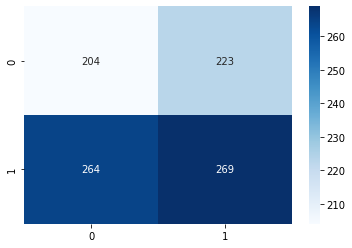

In [44]:
Confusion_Matrix(net,test_loader)

In [73]:
#with open("NO_PUNCT/Validation_Losses_NO_PUNCT","w") as f:
#    json.dump(val_losses,f)
#with open("NO_PUNCT/Training_Loss_NO_PUNCT","w") as f:
#    json.dump(train_loss,f)

## PRETRAINED EMBEDDINGS

In [45]:
from gensim.models import KeyedVectors
goog_wordvecs = KeyedVectors.load_word2vec_format('EMBEDDINGS/GoogleNews-vectors-negative300.bin', binary=True, limit=100000)

In [46]:
def embed_2_tensor(keyedvector_word2vec):
    weights = torch.FloatTensor(goog_wordvecs.vectors)
    oov_size=0
    for i in vocab_2_int.keys():
        if i not in goog_wordvecs.key_to_index.keys():
            oov_size+=1
    zeros = torch.rand(oov_size,weights.shape[1])
    weights = torch.cat([weights,zeros],0)
    weights.requires_grad = True
    return weights

In [47]:
pretrained_embeddings = embed_2_tensor(goog_wordvecs)

In [53]:
loss = nn.BCELoss()
vocab_size = len(set([i for x in data for i in x])) + 1
epochs= 12
output_size = 1
embed_size = 300
hidden_dim = 128
clip = 0.2
n_layers = 2
batch_size = 16
net = LSTM(vocab_size,output_size,embed_size,hidden_dim,n_layers,pretrained_embeddings,drop_prob=0.2)
optim = torch.optim.AdamW(net.parameters(),lr=0.0002)
name_file = "NO_PUNCT/MODELS/pretrained.pt"

Embedding(102117, 300)


In [54]:
net_,val_losses,train_loss = train_nn(net,epochs,loss,optim,train_loader,val_loader,name_file)

Saving model -- Validation Loss decreased from inf to 0.6855
Epoch: 1, batch: 240/480, training loss is 0.686
Epoch: 1, batch: 240/480, avg validation loss is 0.686
Epoch: 1, batch: 240/480, validation accuracy is 0.555
-----
Saving model -- Validation Loss decreased from 0.6855 to 0.6783
Epoch: 1, batch: 480/480, training loss is 0.729
Epoch: 1, batch: 480/480, avg validation loss is 0.678
Epoch: 1, batch: 480/480, validation accuracy is 0.582
-----
Saving model -- Validation Loss decreased from 0.6783 to 0.6750
Epoch: 2, batch: 240/480, training loss is 0.671
Epoch: 2, batch: 240/480, avg validation loss is 0.675
Epoch: 2, batch: 240/480, validation accuracy is 0.592
-----
Saving model -- Validation Loss decreased from 0.6750 to 0.6678
Epoch: 2, batch: 480/480, training loss is 0.723
Epoch: 2, batch: 480/480, avg validation loss is 0.668
Epoch: 2, batch: 480/480, validation accuracy is 0.600
-----
Epoch: 3, batch: 240/480, training loss is 0.648
Epoch: 3, batch: 240/480, avg validati

#### Before starting this project I knew I would have faced serious troubles due to the sanity of the labels: unluckily a large percentage of input labeled as 0 were in reality 1 but still I needed to put into practice what I've learnt during my Deep Learning Nanodegree and therefore I decided to go on.
#### The lessons I've learnt during this project are 1) Neural Network need a lot of data and might not be the best choice with small datasets 2) I experienced on my skin what GIGO truly is (due to labels) and undirecty I've noticed the limit of supervised-learning too: in fact in order to be useful it needs tons of correctly labeled data, a requirement that might be hard to get in real word. A possible solution in this kind of scenarios might be document-embedding and then clustering, but I give you effort to dive into that jungle.

Embedding(102117, 300)
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       427
           1       0.68      0.53      0.60       533

    accuracy                           0.60       960
   macro avg       0.61      0.61      0.60       960
weighted avg       0.62      0.60      0.60       960



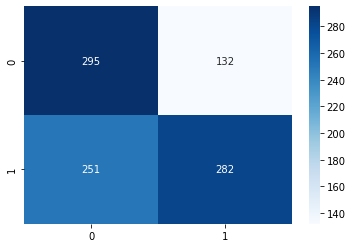

In [51]:
net_ = LSTM(vocab_size,output_size,embed_size,hidden_dim,n_layers,pretrained_embeddings,drop_prob=0.3)
net_.cuda().load_state_dict(torch.load('NO_PUNCT/MODELS/pretrained.pt'))
Confusion_Matrix(net,test_loader)